# Play with pipeline

### Import

In [1]:
import os
PROJECT_PATH=os.getenv("IBENS_PROJECT_PATH") #Si bug: source ~/.bashrc
os.chdir(PROJECT_PATH)

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#DataModule
from disdiff_adaptaters.data_module import Shapes3DDataModule ,BloodMNISTDataModule
#Module
from disdiff_adaptaters.arch.vae import *
from disdiff_adaptaters.arch.multi_distillme import *
#utils
from disdiff_adaptaters.utils import *
#loss
from disdiff_adaptaters.loss import *
#metric
from disdiff_adaptaters.metric import *
#ext
from chada.backbones.vit.chada_vit import ChAdaViT

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer

BATCH_SIZE = 32
LATENT_DIM = 64
DEVICE, is_gpu = set_device(pref_gpu=0)


/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Nombre de GPU : 2

[ GPU 0 ]
Nom : Tesla M40
Mémoire totale : 11.99 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go

[ GPU 1 ]
Nom : Tesla M40 24GB
Mémoire totale : 24.05 Go
Mémoire utilisée : 0.0 Go
Mémoire réservée : 0.0 Go
current device is 0


/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/timm/optim/optim_factory.py:7: FutureWarning: Importing from timm.optim.optim_factory is deprecated, please import via timm.optim
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.optim", FutureWarning)


## Load data 

**Choose the appropriate set :**

### 3DShapes

In [2]:
if is_gpu :
    #6mn30 from ens cluster
    shapes = Shapes3DDataModule(batch_size=BATCH_SIZE)
    shapes.prepare_data()
    shapes.setup(stage='fit')
    shapes_loader = shapes.train_dataloader()
else :
    images, labels = load_h5(Shapes3D.Path.H5)
    images = images[:32]
    labels = labels[:32]
    shapes_loader = DataLoader(TensorDataset(torch.tensor(images).permute(0,3,1,2), torch.tensor(labels)), batch_size=8, shuffle=True)

npz file loading.
start split
end split


/import/pr_compures/alexandre/disdiff_adaptaters/disdiff_adaptaters/utils/utils.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(train_data), torch.tensor(train_label), torch.tensor(test_data), torch.tensor(test_label)


save tensors

tensors saved.
loading of tensors - train
loading of tensors - val
load dataset - train
load dataset val
tensors loaded.


In [3]:
for batch in shapes_loader :
    images, labels = batch
    print(images.shape)
    break

torch.Size([8, 3, 64, 64])


### BloodMNIST

In [2]:
blood = BloodMNISTDataModule(batch_size=BATCH_SIZE)
blood.prepare_data()
blood.setup("fit")
blood_loader = blood.train_dataloader()

### Choose the correct loader

In [3]:
loader = blood_loader
stop_at = 0

for batch in loader :
    images, labels = batch
    in_channels = images.shape[1]
    img_size = images.shape[2]
print(f"Data selected with in_channels={in_channels} and img_size={img_size}")

Data selected with in_channels=3 and img_size=28


## VAE

### Variational Encoder

Let's display the PCA-latent space with VAE encoder

In [11]:
encoder = Encoder(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)

encoder.eval()
mus = []
logvars = []
labels = []

for i,batch in enumerate(loader) :
    image, label = batch

    mu, logvar = encoder(image)

    mus.append(mu)
    logvars.append(logvar)
    labels.append(label)
    if (stop_at is not None) and (stop_at == i) : break

try :
    mus = torch.cat(mus)
    logvars = torch.cat(logvars)
    labels = torch.cat(labels)
except TypeError as e : print("!!You have already run this cell.!!")
print(f"labels shape = {labels.shape}")

labels shape = torch.Size([8, 1])


Make sure that labels shape is at [Batch size, 1]. Preprocess here if needed :

In [12]:
#labels[:, 0].unsqueeze(1).shape

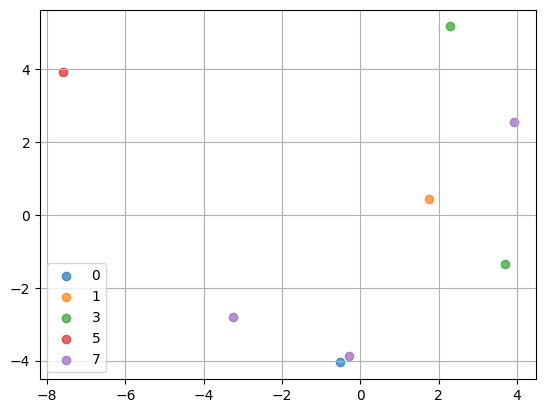

In [13]:
assert labels.shape == (labels.shape[0], 1), "You have to preprocess labels before using pca_latent display function"
pca_latent(labels=labels, mu_logvars=(mus, logvars))

### Decoder

In [14]:
#Sample latent
z = sample_from((mus, logvars))
print(f"Latent space is a {z.shape}")
decoder = Decoder(out_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, out_encoder_shape=encoder.out_encoder_shape)
x_hat_logits = decoder(z)
try: assert x_hat_logits.shape == (x_hat_logits.shape[0], in_channels, img_size, img_size)
except AssertionError as e : 
    print(x_hat_logits.shape)
    print("!!!!WARNING : reconstruction error : output of the decoder must be with the a same shape as the input")

Latent space is a torch.Size([8, 64])
28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


tensor(0.4862, grad_fn=<MinBackward1>) tensor(0.5526, grad_fn=<MaxBackward1>)


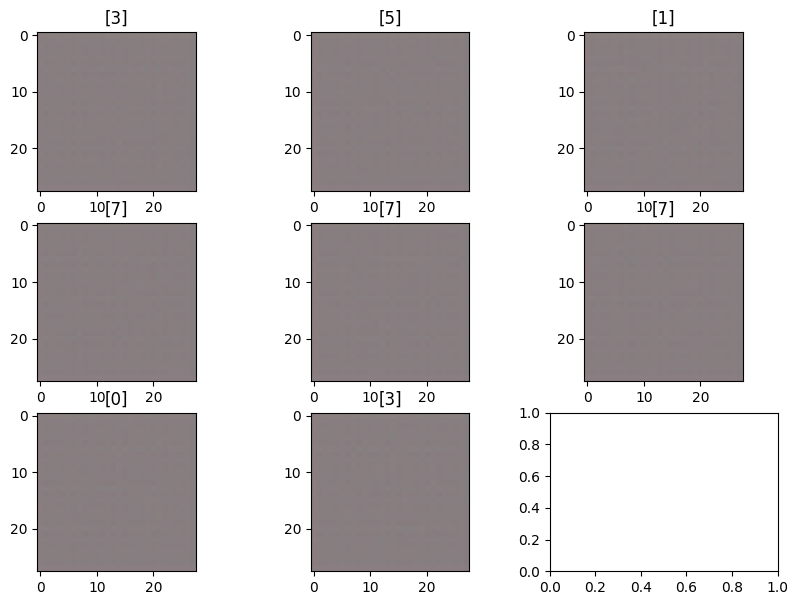

In [17]:
assert x_hat_logits.shape==image.shape, "shape error"
print(x_hat_logits.min(), x_hat_logits.max())
display((x_hat_logits, labels))
loss_mse = mse(x_hat_logits, image)
loss_kl = kl(*(mus, logvars))

In [18]:
loss_mse+loss_kl

tensor(1857.5347, grad_fn=<AddBackward0>)

### VAE - train

In [11]:
beta=0
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")

Sanity check : torch.Size([32, 3, 28, 28])


Prior to any train :

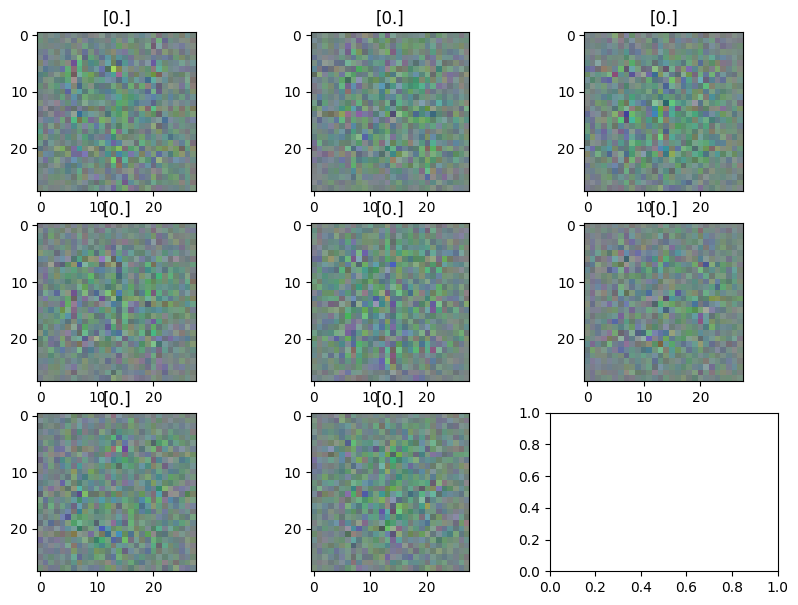

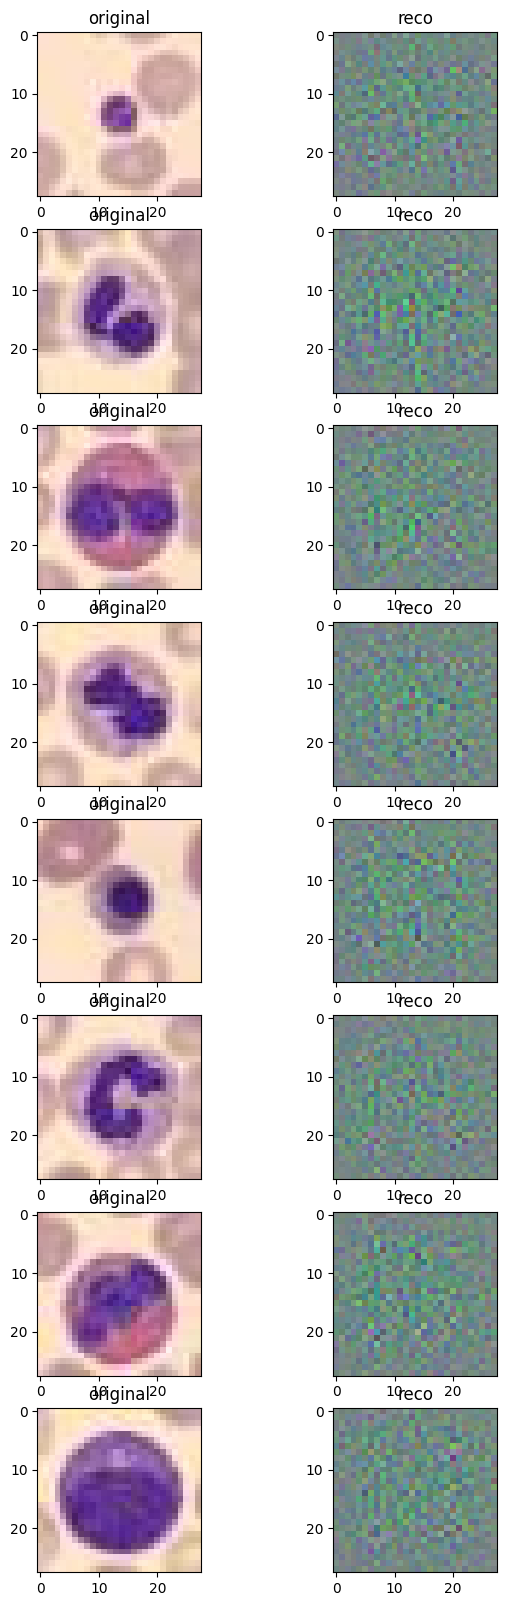

In [13]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

In [14]:
max_epoch=5
version=f"vae_epoch={max_epoch}_beta={beta}_latent={LATENT_DIM}"
trainer = Trainer(
        accelerator="auto",
        devices="1",
        max_epochs=max_epoch,
        logger=TensorBoardLogger(
            save_dir=LOG_DIR+"/vae",
            name=BloodMNIST.Path.VAE,
            version=version,
            default_hp_metric=False,
        ),
        callbacks=[
            ModelCheckpoint(monitor="loss/val", mode="min"),
            LearningRateMonitor("epoch"),
        ]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(vae, blood)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | _VAE | 2.0 M  | train
---------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.187     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 126.43it/s]Val loss: 0.09577439725399017
                                                                            

/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/projects/compures/alexandre/disdiff_adaptaters/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 298/298 [00:06<00:00, 48.44it/s, v_num=t=64]Val loss: 0.02450312115252018
Val loss: 0.025002676993608475
Val loss: 0.02386321872472763
Val loss: 0.022712411358952522
Val loss: 0.02387646585702896
Val loss: 0.022996652871370316
Val loss: 0.023694856092333794
Val loss: 0.02404060959815979
Val loss: 0.023484395816922188
Val loss: 0.022998414933681488
Val loss: 0.023879699409008026
Val loss: 0.024152154102921486
Val loss: 0.024366792291402817
Val loss: 0.02400626800954342
Val loss: 0.02445302903652191
Val loss: 0.02440638467669487
Val loss: 0.02434639073908329
Val loss: 0.02340790256857872
Val loss: 0.023065511137247086
Val loss: 0.024854425340890884
Val loss: 0.024537499994039536
Val loss: 0.02451215870678425
Val loss: 0.02292579784989357
Val loss: 0.02400059998035431
Val loss: 0.02364405430853367
Val loss: 0.024481281638145447
Val loss: 0.023826081305742264
Val loss: 0.024099789559841156
Val loss: 0.023326076567173004
Val loss: 0.02318214811384678
Val loss: 0.02

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 298/298 [00:06<00:00, 43.75it/s, v_num=t=64]


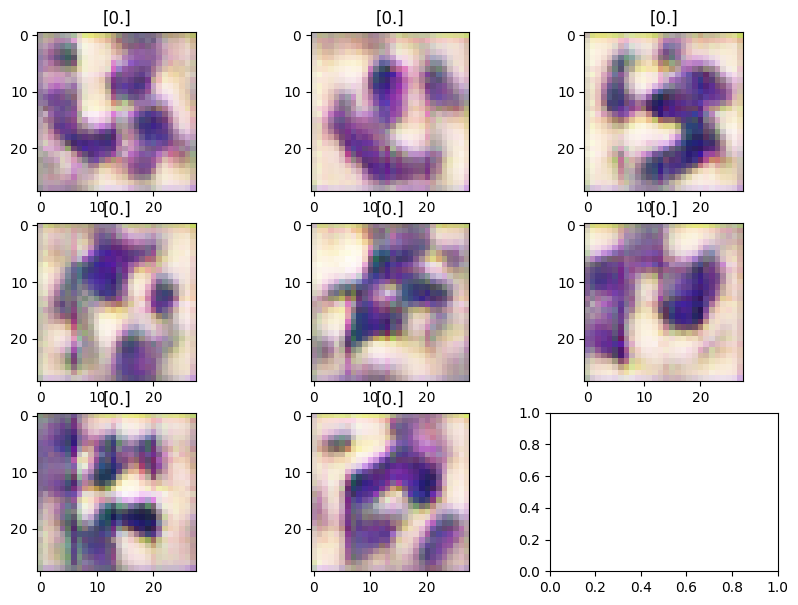

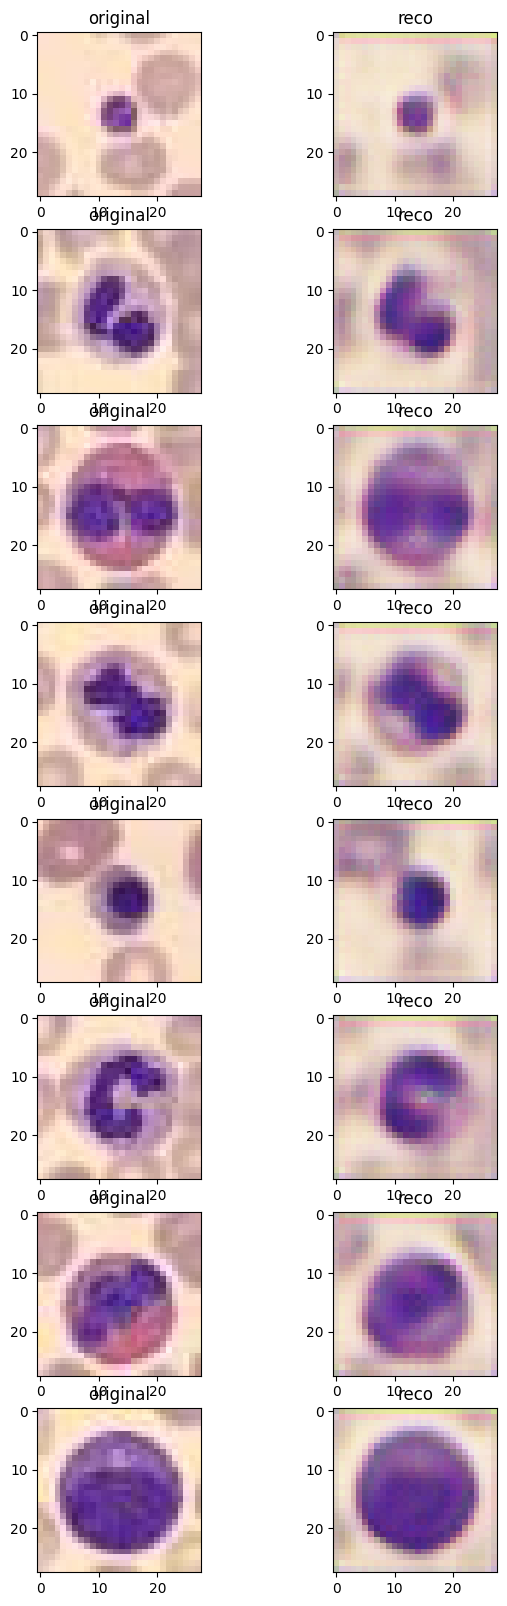

In [16]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

Then with beta at 10 :

In [40]:
beta=10e-5
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")

max_epoch=5
version=f"vae_epoch={max_epoch}_beta={beta}_latent={LATENT_DIM}"
trainer = Trainer(
        accelerator="auto",
        devices="1",
        max_epochs=max_epoch,
        logger=TensorBoardLogger(
            save_dir=LOG_DIR+"/vae",
            name=BloodMNIST.Path.VAE,
            version=version,
            default_hp_metric=False,
        ),
        callbacks=[
            ModelCheckpoint(monitor="loss/val", mode="min"),
            LearningRateMonitor("epoch"),
        ]
    )
trainer.fit(vae, blood)

#vae.reconstruct()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity check : torch.Size([32, 3, 28, 28])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | _VAE | 2.0 M  | train
---------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.187     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 298/298 [00:06<00:00, 48.50it/s, v_num=t=64]Val loss: 0.0458502396941185
Val loss: 0.046102482825517654
Val loss: 0.04367809370160103
Val loss: 0.03982337936758995
Val loss: 0.0416422039270401
Val loss: 0.04365593567490578
Val loss: 0.04362905025482178
Val loss: 0.04405222460627556
Val loss: 0.04328010603785515
Val loss: 0.04123556241393089
Val loss: 0.04227699339389801
Val loss: 0.04335058853030205
Val loss: 0.04498374089598656
Val loss: 0.04324907436966896
Val loss: 0.045334797352552414
Val loss: 0.0439598448574543
Val loss: 0.04317039996385574
Val loss: 0.04232238605618477
Val loss: 0.04119773581624031
Val loss: 0.044651925563812256
Val loss: 0.04468757286667824
Val loss: 0.044374532997608185
Val loss: 0.041081495583057404
Val loss: 0.04421533644199371
Val loss: 0.04432389885187149
Val loss: 0.041167598217725754
Val loss: 0.043319664895534515
Val loss: 0.04403106868267059
Val loss: 0.04119793698191643
Val loss: 0.04237795248627663
Val loss: 0.04404391720890

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 298/298 [00:06<00:00, 42.78it/s, v_num=t=64]


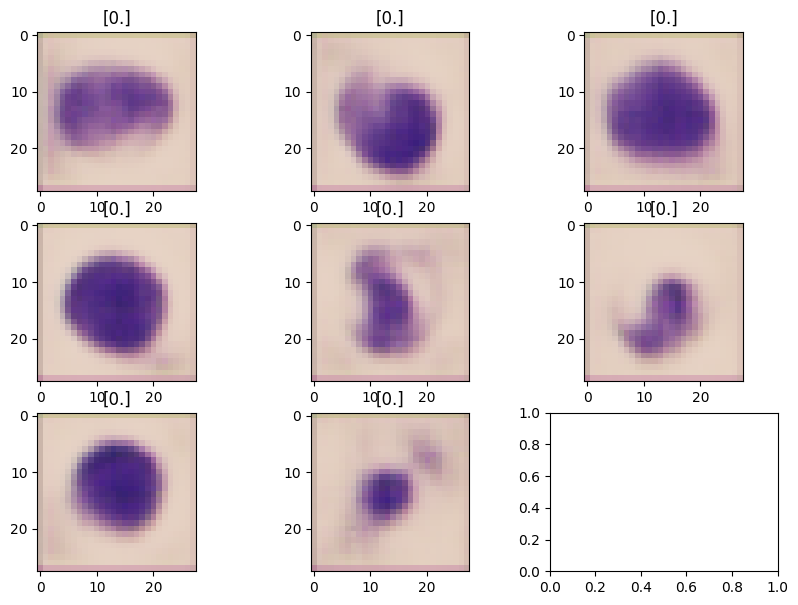

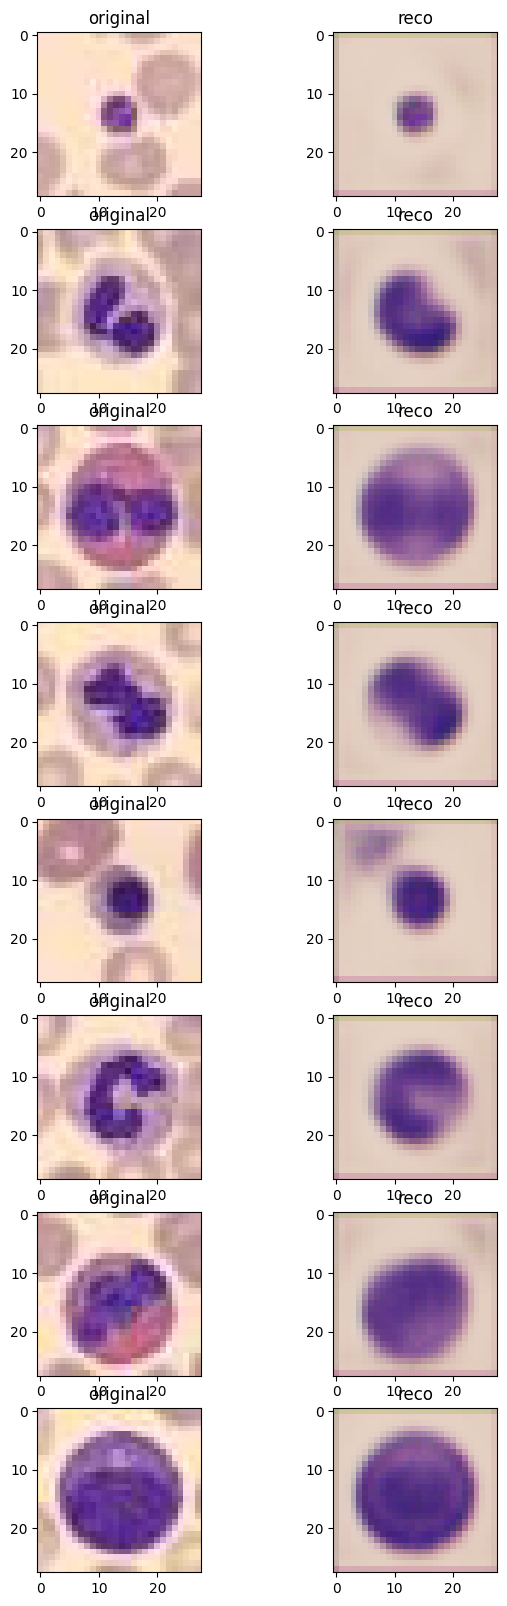

In [41]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

#### [DEBUG VAE]

##### Test - loss

In [ ]:
#kl test
mu = torch.tensor([[0,0,0,0]])
logvar = torch.tensor([[0, 0, 0, 0]])
kl_loss = kl(mu, logvar)
assert abs(kl_loss - 0.0) < 10e-3, "Error in kl implementation"
print(f"kl ok. kl={kl_loss}")

#mse test
k=2
images_hat_logits = torch.zeros([1, 3, 28, 28])
images = k*torch.ones([1, 3, 28, 28])
mse_loss = mse(images_hat_logits, images)
assert abs(mse_loss-k**2) < 10e-3
print(f"mse ok. mse={mse_loss}")

kl ok. kl=0.0
mse ok. mse=4.0


In [ ]:
test = torch.load("/projects/compures/alexandre/disdiff_adaptaters/disdiff_adaptaters/data/bloodmnist/bloodmnist_test.pt")

In [ ]:
test[0].shape

torch.Size([3421, 3, 28, 28])

##### Auto Encoder (VAE without sampling and only reco loss)

In [4]:
ae = AEModule.load_from_checkpoint("disdiff_adaptaters/logs/ae/shapes/ae_epoch=10_beta=1.0_latent=128/checkpoints/epoch=9-step=384000.ckpt")

In [1]:
ae.show_reconstruct(images)

NameError: name 'ae' is not defined

## Multi-Distillme

From "load data" images.shape=torch.Size([8, 3, 28, 28])
28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


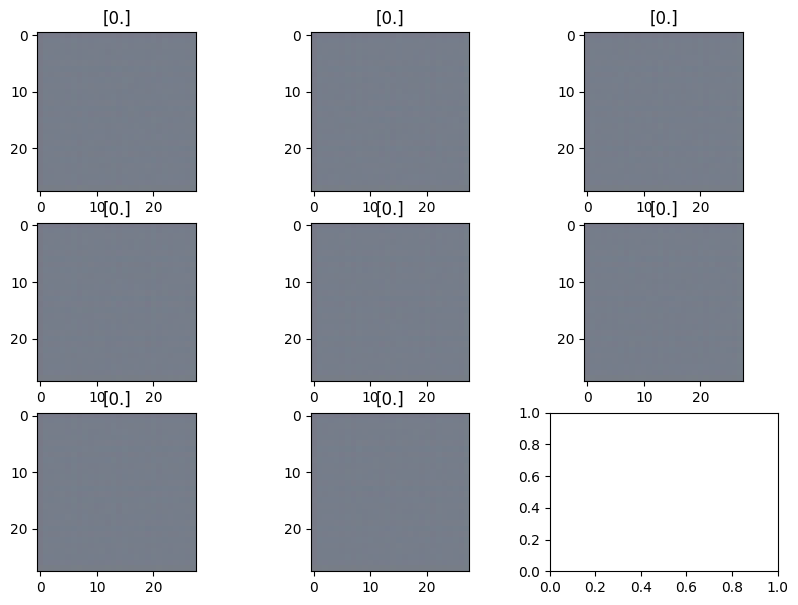

In [ ]:
multi_dm = MultiDistillMeModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)
print(f"From \"load data\" images.shape={images.shape}")

images_gen = multi_dm.generate()
labels_gen = torch.zeros([images_gen.shape[0],1])
display((images_gen, labels_gen))

In [14]:
import torch
from lightning import LightningModule

from disdiff_adaptaters.arch.vae import *
from disdiff_adaptaters.utils import sample_from, pca_latent, display
from disdiff_adaptaters.loss import *


class _MultiDistillMe(torch.nn.Module) : 
    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int) :
        
        super().__init__()

        self.encoder_s = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim)
        
        self.encoder_t = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim)
        
        self.merge_operation = torch.add
        
        self.decoder = Decoder(out_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,
                               out_encoder_shape=self.encoder_s.out_encoder_shape)
        
        self.labels_buff = []
        self.latent_buff = []
        
    def forward(self, images: torch.Tensor) :

        #forward t
        mus_logvars_s = self.encoder_s(images)
        z_s = sample_from(mus_logvars_s)

        #forward_t
        mus_logvars_t = self.encoder_t(images)
        z_t = sample_from(mus_logvars_t)

        #merge latent vector from s and t
        z = self.merge_operation(z_s, z_t)

        #decoder
        image_hat_logits = self.decoder(z)

        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
class MultiDistillMeDataModule(LightningModule) :

    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int,
                 beta_s: float=1.0,
                 beta_t: float=1.0) :
        
        super().__init__()
        self.save_hyperparameters()

        self.model = _MultiDistillMe(in_channels=self.hparams.in_channels,
                                     img_size=self.hparams.img_size,
                                     latent_dim=self.hparams.latent_dim,)
            
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters())
    
    def generate(self, nb_samples: int=8) :
        eps_s = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim]))
        eps_t = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim]))
        z = self.model.merge_operation(eps_s, eps_t)

        x_hat_logits = self.model.decoder(z)
        return x_hat_logits
    
    def forward(self, images: torch.Tensor) :
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.model(images)
        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
    def loss(self, mus_logvars_s, mus_logvars_t, image_hat_logits, images, log_components=False) :

        weighted_kl_s = self.hparams.beta_s*kl(mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(mus_logvars_t)
        reco = mse(image_hat_logits, images)

        if log_components :
            self.log("loss/kl_s", weighted_kl_s)
            self.log("loss/kl_t", weighted_kl_t)
            self.log("loss/reco", reco)

        return weighted_kl_t+weighted_kl_s+reco
    
    def training_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits, log_components=True)

        print(f"Train loss: {loss}")
        
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        self.log("loss/train", loss)
        return loss

    def validation_step(self, batch: tuple[torch.Tensor]):
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits)

        self.log("loss/val", loss)
        print(f"Val loss: {loss}")
    
    def test_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)

        weighted_kl_s = self.hparams.beta_s*kl(mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(mus_logvars_t)
        reco = mse(image_hat_logits, images)

        self.log("loss/reco_test", reco)
        self.log("loss/kl_s_test", weighted_kl_s)
        self.log("loss/kl_t_test", weighted_kl_t)
        self.log("loss/test", reco+weighted_kl_t+weighted_kl_s)

    def on_test_end(self):
        images_gen = self.generate()
        labels_gen = torch.zeros([images_gen.shape[0],1])
        display((images_gen, labels_gen))
        self.logger = TensorBoardLogger
        self.logger.log_image()


28 is not a power of 2. Interpolation from this shape to (torch.Size([192, 4, 4]), torch.Size([192, 4, 4]))


AttributeError: can't set attribute 'logger'

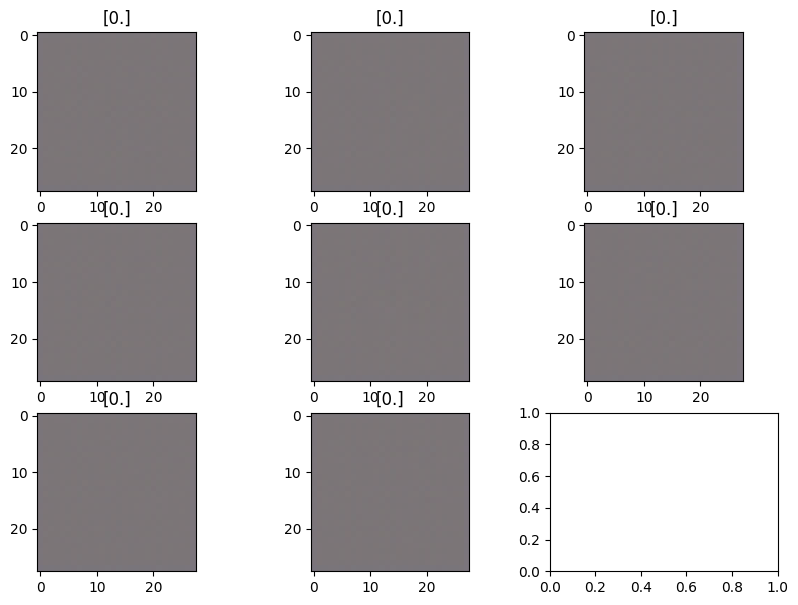

In [15]:
multi_dm = MultiDistillMeDataModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)
multi_dm.on_test_end()